# Initialization

In [ ]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import backend as K

In [ ]:
data_dir = "drive/MyDrive/University/7 semestras/Kursinis/data"
images_dir = os.path.join(data_dir, "images")
resized_images_dir = os.path.join(data_dir, "resized_images")
masks_dir = os.path.join(data_dir, "masks")
resized_masks_dir = os.path.join(data_dir, "resized_masks")
checkpoint_dir = os.path.join(data_dir, "checkpoints")
model_augmented_dir = os.path.join(data_dir, "model_augmented")
checkpoints_augmented_dir = os.path.join(data_dir, "checkpoints_augmented")
log_dir = os.path.join(data_dir, "training.log")
figures_dir = os.path.join(data_dir, "figures")

In [ ]:
INPUT_SHAPE = (256, 256)
BATCH_SIZE = 4

# Base images processing and saving to Drive

First resize all base dataset's images to one size and save, so we don't have to resize them again

In [ ]:
for dir in [images_dir, masks_dir]:
  for i, img_name in enumerate(os.listdir(dir)):
    image_path = os.path.join(dir, img_name)
    img = cv.imread(image_path)
    resized_img = cv.resize(img, (INPUT_SHAPE[0], INPUT_SHAPE[1]), interpolation=cv.INTER_AREA)

    cv.imwrite(os.path.join(resized_images_dir if "images" in dir else resized_masks_dir, img_name), resized_img)

# Utility functions

In [ ]:
def show_image(img):
  plt.imshow(img, cmap='gray')
  plt.show()

def show_images(labels, *images):
  fig = plt.figure(figsize=(10, 7))
  # setting values to rows and column variables
  rows = 1
  columns = len(images)

  for i, image in enumerate(images):
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i + 1)

    # showing image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(labels[i] if i + 1 <= len(labels) else i)

# Model: preprocessing

### Load images and their masks

In [ ]:
def load_images_and_masks(images_dir, masks_dir):
  images_arr = []
  masks_arr = []
  for i, img_name in enumerate(os.listdir(masks_dir)):
    image_path = os.path.join(images_dir, img_name)
    mask_path = image_path.replace(images_dir, masks_dir)
    img = cv.imread(image_path)

    if (os.path.isfile(mask_path)):
      mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
      mask = np.expand_dims(mask, axis=-1)
      images_arr.append(img)
      masks_arr.append(mask)

  return (images_arr, masks_arr)

(raw_images, raw_masks) = load_images_and_masks(resized_images_dir, resized_masks_dir)

## Preprocess images and split to datasets

### Define augmentation function

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

# Apply data augmentation on-the-fly using tf.data and map
def augment(image, mask, override_augmentation=None):
    number = override_augmentation or random.randint(0, 3)

    # Flip the image and mask horizontally
    if (number == 0):
      new_image = tf.image.flip_left_right(image)
      new_mask = tf.image.flip_left_right(mask)
    # Flip the image and mask vertically
    elif (number == 1):
      new_image = tf.image.flip_up_down(image)
      new_mask = tf.image.flip_up_down(mask)
    # Zoom in 70%
    elif (number == 2):
      new_image = tf.image.central_crop(image, central_fraction=0.8)  # Zoom in to 70% of the image
      new_image = tf.image.resize(new_image, [INPUT_SHAPE[0], INPUT_SHAPE[1]])
      new_mask = tf.image.central_crop(mask, central_fraction=0.8)
      new_mask = tf.image.resize(new_mask, [INPUT_SHAPE[0], INPUT_SHAPE[1]])
    # Randomly rotate the image and mask
    # Concatenate image and mask to make sure the same rotation is applied
    else:
      combined = tf.concat([image, mask], axis=-1)
      # rotations = tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32)
      rotations = 1
      combined = tf.image.rot90(combined, rotations)
      new_image, new_mask = tf.split(combined, [image.shape[-1], mask.shape[-1]], axis=-1)

    new_mask = tf.round(new_mask)

    return new_image, new_mask

### Normalize and augment images

In [ ]:
# Normalize the images and masks
images = np.array(raw_images, dtype=np.float32) / 255.0
masks = np.array(raw_masks, dtype=np.float32) / 255.0

# Augment the same images
augment_fun = lambda image_mask: augment(*image_mask)
augmented_pairs = [augment_fun(pair) for pair in zip(images, masks)]
augmented_images, augmented_masks = zip(*augmented_pairs)

# Concatenate non-augmented and augmented images
images = np.concatenate((images, augmented_images), axis=0)
masks = np.concatenate((masks, augmented_masks), axis=0)

2
0
1
3
3
2
3
2
1
2
3
0
0
1
2
0
1
1
3
3
0
3
0
0
0
0
1
1
1
3
2
1
3
2
2
3
1
1
0
0
3
3
1
1
1
0
0
3
1
1
1
3
0
1
3
0
2
3
2
2
3
3
3
3
3
3
3
3
1
1
2
0
3
0
0
1
1
0
0
2
3
1
3
1
0
2
3
2
3
0
0
0
1
2
0
3
3
1
2
1
2
0
1
2
1
2
2
0
2
0
1
0
3
1
0
0
3
2
3
3
0
2
2
1
3
2
0
1
3
0
0
1
1
2
2
3
3
3
2
0
3
2
1
1
3
1
2
1
0
3
2
0
2
1
1
1
1
2
0
3
2
2
0
1
1
1
2
2
3
3
2
1
3
1
3
3
2
0
2
1
2
1
2
0
0
3
0
3
3
0
1
0
0
1
2
1
0
0
3
3
0
1
2
3
1
0
2
1
0
2
0
2
2
0
0
2
0
0
2
0
0
3
0
3
0
2
3
1
0
1
3
3
0
2
0
1
3
0
3
0
3
0
1
3
0
1
3
0
3
3
1
1
2
3
0
1
3
2
1
2
3
3
0
1
1
1
1
2
3
3
0
1
1
2
2
1
2
1
1
2
0
2
0
3
3
3
2
2
1
0
0
3
3
3
3
1
0
2
1
2
0
0
2
0
0
1
1
1
2
3
2
2
0
3
3
1
3
0
2
2
0
0
3
2
0
3
1
3
2
1
0
2
1
3
2
2
2
0
2
3
3
1
1
1
1
3
0
3
0
1
3
0
0
2
0
2
2
2
0
3
2
0
1
0
1
1
0
0
3
1
3
3
0
2
0
1
3
2
0
1
0
0
2
0
0
2
1
2
1
0
3
3
1
3
0
2
3
0
2
3
3
1
2


### Split to datasets

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.1, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Convert your NumPy arrays into a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Cache, shuffle, batch, and prefetch the combined dataset
train_dataset = train_dataset.cache().shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# For the validation dataset, no augmentation is applied
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### Calculate positive (microplastic) class weight

In [ ]:
TOTAL_PIXELS = INPUT_SHAPE[0] * INPUT_SHAPE[1] * len(raw_masks)
MP_PIXELS = 0
for mask in raw_masks:
  MP_PIXELS += np.count_nonzero(mask > 0)

# TOTAL_PIXELS = 0
# MP_PIXELS = 0

# for (image_batch, mask_batch) in train_dataset:
#   for (image, mask) in zip(image_batch, mask_batch):
#     mp_pixels = np.count_nonzero(mask > 0)
#     MP_PIXELS += mp_pixels
#     TOTAL_PIXELS += (INPUT_SHAPE[0] * INPUT_SHAPE[1])

print("Average MP in pictures: ", round(MP_PIXELS / TOTAL_PIXELS * 100, 2), "%")
POS_WEIGHT = (1 / (MP_PIXELS / TOTAL_PIXELS))
print("POS_WEIGHT", POS_WEIGHT)

Average MP in pictures:  0.73 %
POS_WEIGHT 137.8135804595002


# Model: model building and training

### Build model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout

# def build_unet_model(input_shape, num_filters=32, activation = 'relu'):
def build_unet_model(input_shape, num_filters=64, activation = 'relu'):
  inputs = Input(input_shape)

  c1 = Conv2D(num_filters, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (inputs)
  c1 = Conv2D(num_filters, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(num_filters*2, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (p1)
  c2 = Conv2D(num_filters*2, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(num_filters*4, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (p2)
  c3 = Conv2D(num_filters*4, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(num_filters*8, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (p3)
  c4 = Conv2D(num_filters*8, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c4)
  c4 = Dropout(0.3) (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(num_filters*16, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (p4)
  c5 = Conv2D(num_filters*16, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c5)
  c5 = Dropout(0.3) (c5)

  u6 = Conv2DTranspose(num_filters*8, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(num_filters*8, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (u6)
  c6 = Conv2D(num_filters*8, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c6)

  u7 = Conv2DTranspose(num_filters*4, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(num_filters*4, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (u7)
  c7 = Conv2D(num_filters*4, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c7)

  u8 = Conv2DTranspose(num_filters*2, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(num_filters*2, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (u8)
  c8 = Conv2D(num_filters*2, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c8)

  u9 = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(num_filters, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (u9)
  c9 = Conv2D(num_filters, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

### Create F1 metric

In [ ]:
# Custom F1 metric function
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.where(y_pred > self.threshold, 1., 0.)
        y_true = tf.reshape(y_true, shape=(-1,))
        y_pred = tf.reshape(y_pred, shape=(-1,))

        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

### Define loss functions

In [ ]:
def weighted_binary_crossentropy(pos_weight):
    """
    A weighted version of keras.objectives.binary_crossentropy
    Variables:
        pos_weight: A coefficient to use on the positive classes
    """
    def loss(y_true, y_pred):
        # Transform to logits
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        y_pred_logit = tf.math.log(y_pred / (1 - y_pred))

        loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred_logit, labels=y_true, pos_weight=pos_weight)
        return tf.reduce_mean(loss, axis=-1)

    return loss

# wbce = weighted_binary_crossentropy(POS_WEIGHT)
wbce = weighted_binary_crossentropy(200)

In [ ]:
def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_loss(y_true, y_pred, smooth = 1e-5):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [ ]:
def dice_with_wbce(y_true, y_pred):
  dice_loss_val = dice_loss(y_true, y_pred)
  wbce_loss_val = wbce(y_true, y_pred)
  return dice_loss_val + wbce_loss_val

### Unused losses

In [ ]:
smooth = 0.5

def tversky_index(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (
            1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky_index(y_true, y_pred)

def focal_tversky(y_true, y_pred):
    pt_1 = tversky_index(y_true, y_pred)
    gamma = 0.75
    return K.pow((1 - pt_1), gamma)

In [ ]:
import tensorflow.keras.backend as K

def focal_loss(y_true, y_pred, gamma=1.5, alpha=100):
    """
    Focal loss function.

    Parameters:
        y_true: Tensor of true labels.
        y_pred: Tensor of predicted labels.
        gamma: Modulating factor to adjust the rate at which easy examples are down-weighted.
        alpha: Weighting factor for the class labels.

    Returns:
        Computed focal loss.
    """
    # Calculate the binary cross-entropy loss
    bce = K.binary_crossentropy(y_true, y_pred)

    # Compute the weights based on the predictions
    pt = K.exp(-bce)  # pt is the probability of being classified correctly
    focal_loss = alpha * K.pow((1 - pt), gamma) * bce

    return K.mean(focal_loss)

### Compile the model

In [ ]:
# Define threshold for determining if model output is MP or background
THRESHOLD = 0.5

In [ ]:
# Instantiate the U-Net model
input_shape = (256, 256, 3)
unet_model = build_unet_model(input_shape)

# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.0001)

metrics = [
  'accuracy',
  tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=THRESHOLD, name="binary_io_u"),
  tf.keras.metrics.Precision(thresholds=THRESHOLD, name="precision"),
  tf.keras.metrics.Recall(thresholds=THRESHOLD, name="recall"),
  F1Score(threshold=THRESHOLD, name="f1_score")
]

# Compile model with custom loss function
# unet_model.compile(optimizer=optimizer, loss=wbce, metrics=metrics)
unet_model.compile(optimizer=optimizer, loss=dice_loss, metrics=metrics)
# unet_model.compile(optimizer=optimizer, loss=dice_with_wbce, metrics=metrics)
# unet_model.compile(optimizer=optimizer, loss=focal_loss, metrics=metrics)
# unet_model.compile(optimizer=optimizer, loss=focal_tversky, metrics=metrics)

### Summary

In [ ]:
unet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 256, 256, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 conv2d_96 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_95[0][0]']           
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 128, 128, 64)         0         ['conv2d_96[0][0]']           
 ng2D)                                                                                      

### Setup model directories

In [ ]:
# Model names
dice_smooth_1eminus5_thresh_90 = "dice_smooth_1eminus5_thresh_90"
dice_smooth_1_thresh_90 = "dice_smooth_1_thresh_90"
dice_smooth_1eminus5_thresh_70 = "dice_smooth_1eminus5_thresh_70"
dice_smooth_1eminus5_thresh_50 = "dice_smooth_1eminus5_thresh_50"
dice_smooth_1eminus5_thresh_70_relu = "dice_smooth_1eminus5_thresh_70_relu"
dice_smooth_1eminus5_thresh_50_relu = "dice_smooth_1eminus5_thresh_50_relu"

dice_smooth_1eminus5_thresh_50_relu_batch_4_filters_64 = "dice_smooth_1eminus5_thresh_50_relu_batch_4_filters_64"

wbce_208_thresh_90 = "wbce_208_thresh_90"
wbce_208_thresh_70 = "wbce_208_thresh_70"
wbce_208_thresh_70_relu = "wbce_208_thresh_70_relu"
wbce_208_thresh_50 = "wbce_208_thresh_50"
wbce_208_thresh_50_relu = "wbce_208_thresh_50_relu"
wbce_200_thresh_50_relu_batch_4_filters_64 = "wbce_200_thresh_50_relu_batch_4_filters_64"

dice_smooth_1eminus5_wbce_208_thresh_90 = "dice_smooth_1eminus5_wbce_208_thresh_90"
dice_smooth_1eminus5_wbce_208_thresh_70 = "dice_smooth_1eminus5_wbce_208_thresh_70"
dice_smooth_1eminus5_wbce_208_thresh_50 = "dice_smooth_1eminus5_wbce_208_thresh_50"
dice_smooth_1eminus5_wbce_208_thresh_70_relu = "dice_smooth_1eminus5_wbce_208_thresh_70_relu"
dice_smooth_1eminus5_wbce_208_thresh_50_relu = "dice_smooth_1eminus5_wbce_208_thresh_50_relu"
dice_smooth_1eminus5_wbce_208_thresh_50_relu_2 = "dice_smooth_1eminus5_wbce_208_thresh_50_relu_2"

dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64 = "dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64"

focal_gamma_15_alpha_193_relu = "focal_gamma_15_alpha_193_relu"
focal_gamma_11_alpha_193_relu = "focal_gamma_11_alpha_193_relu"
focal_gamma_2_alpha_193_relu = "focal_gamma_2_alpha_193_relu"
focal_gamma_3_alpha_193_relu = "focal_gamma_3_alpha_193_relu"
focal_gamma_15_alpha_100_relu = "focal_gamma_15_alpha_100_relu"

# CURRENT MODEL
current_model = dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64
# current_model = wbce_200_thresh_50_relu_batch_4_filters_64

# Logger dir
training_logs_dir = os.path.join(data_dir, "training_logs")
current_logger_dir = os.path.join(training_logs_dir, current_model + ".log")

# Model dir
models_dir = os.path.join(data_dir, "models")
current_model_dir = os.path.join(models_dir, current_model)

### Setup callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

checkpoints_augmented_dir = os.path.join(data_dir, "checkpoints_augmented")
checkpoint_dir_with_epochs = os.path.join(checkpoints_augmented_dir, current_model + ".weights.{epoch:02d}-{val_loss:.3f}.hdf5")

# Set up callback for saving model architecture and weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir_with_epochs,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=False,
    mode='min',
)

# Callback for logging model mettrics
csv_logger_callback = CSVLogger(current_logger_dir)

# Set up callback to reduce learning_rate when val_loss plateaus
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

### Load model from storage

In [ ]:
print(current_model_dir)
unet_model = tf.keras.saving.load_model(
    current_model_dir,
    custom_objects={
        "loss": wbce,
        "F1Score": F1Score,
        "dice_with_wbce": dice_with_wbce,
        "weighted_binary_crossentropy": wbce,
        "wbce": wbce,
    },
)

drive/MyDrive/University/7 semestras/Kursinis/data/models/dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64


In [ ]:
checkpoint_dir = os.path.join(checkpoints_augmented_dir, current_model + ".weights.60-0.432.hdf5")
unet_model.load_weights(checkpoint_dir)

### Train model

In [ ]:
print("Now training:", current_model, current_logger_dir, current_model_dir)
# Train the model
history = unet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=[model_checkpoint_callback, csv_logger_callback, reduce_lr_callback],
    batch_size=BATCH_SIZE,
    epochs=120
)

Now training: dice_smooth_1eminus5_thresh_50_relu_batch_4_filters_64 drive/MyDrive/University/7 semestras/Kursinis/data/training_logs/dice_smooth_1eminus5_thresh_50_relu_batch_4_filters_64.log drive/MyDrive/University/7 semestras/Kursinis/data/models/dice_smooth_1eminus5_thresh_50_relu_batch_4_filters_64
Epoch 1/120
182/182 [==============================] - 82s 309ms/step - loss: 0.9793 - accuracy: 0.3781 - binary_io_u: 0.1903 - precision: 0.0054 - recall: 0.6414 - f1_score: 0.0108 - val_loss: 0.9940 - val_accuracy: 0.0027 - val_binary_io_u: 0.0014 - val_precision: 0.0070 - val_recall: 0.9998 - val_f1_score: 0.0140 - lr: 1.0000e-04
Epoch 2/120
182/182 [==============================] - 50s 273ms/step - loss: 0.9935 - accuracy: 0.0037 - binary_io_u: 0.0019 - precision: 0.0053 - recall: 0.9999 - f1_score: 0.0105 - val_loss: 0.9940 - val_accuracy: 0.0039 - val_binary_io_u: 0.0020 - val_precision: 0.0070 - val_recall: 0.9998 - val_f1_score: 0.0140 - lr: 1.0000e-04
Epoch 3/120
182/182 [===

In [ ]:
unet_model.save(current_model_dir)

# Model evaluation and testing

### Evaluate and predict test dataset

In [ ]:
print("Current model", current_model)
scores = unet_model.evaluate(x_test, y_test)
base_predictions = unet_model.predict(x_test)

Current model dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64
2/2 [==============================] - 76s 16s/step


### Evaluate model each 10 epochs

In [ ]:
all_checkpoints = os.listdir(checkpoints_augmented_dir)
filtered_checkpoints = list(filter(lambda checkpoint: True if checkpoint.startswith(current_model) else False, all_checkpoints))

def load_model_and_test(checkpoint):
  checkpoint_dir = os.path.join(checkpoints_augmented_dir, checkpoint)
  print("\nCurrent checkpoint", checkpoint)
  unet_model.load_weights(checkpoint_dir)
  scores = unet_model.evaluate(x_test, y_test)
  print("scores:", scores)

for count, checkpoint in enumerate(filtered_checkpoints, 1): # Start counting from 1
    if count % 10 == 0:
        load_model_and_test(checkpoint)



Current checkpoint dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64.weights.10-1.406.hdf5
2/2 [==============================] - 1s 274ms/step - loss: 0.5000 - accuracy: 0.9960 - binary_io_u: 0.7345 - precision: 0.8005 - recall: 0.5172 - f1_score: 0.6284
scores: [0.4999831020832062, 0.9959694743156433, 0.7344537973403931, 0.8004645705223083, 0.5172232389450073, 0.628402054309845]

Current checkpoint dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64.weights.20-0.761.hdf5
2/2 [==============================] - 1s 185ms/step - loss: 0.4980 - accuracy: 0.9948 - binary_io_u: 0.6733 - precision: 0.6028 - recall: 0.5700 - f1_score: 0.5859
scores: [0.49798351526260376, 0.9948328733444214, 0.6733496785163879, 0.6028256416320801, 0.5699812173843384, 0.5859434604644775]

Current checkpoint dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64.weights.30-0.756.hdf5
2/2 [==============================] - 1s 192ms/step - loss: 0.4069 - accuracy: 0.9956 - binar

### Masks cleanup

In [ ]:
# Minimum size of a particle to be still considered a microplastic
MIN_SIZE = 2

# Function to remove too small particles from prediction mask
def remove_too_small_particles(mask):
  (totalLabels, img_with_labels, stats, centroid) = cv.connectedComponentsWithStats(mask)
  im_result = np.zeros_like(img_with_labels, np.uint8)

  for i, stat in enumerate(stats[1:]):
    size = stat[4]
    if (size) >= MIN_SIZE:
      im_result[img_with_labels == i + 1] = 1

  return im_result

### Counting microplastics from masks

In [ ]:
def count_blobs(image, threshold=128):
  image = image * 255.0
  image = image.astype(np.uint8)
  ret, image = cv.threshold(image, threshold, 255, cv.THRESH_BINARY)

  # Calculate connected components, aka how many MP instances were found in image
  blob_count, _ = cv.connectedComponents(image)
  blob_count -= 1 # Deduct one component, which is the background

  return blob_count

In [ ]:
counting_dir = os.path.join(figures_dir, "counting")

Counting test dataset with model dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64...
Image 0: predicted 2, actual 2
Image 1: predicted 8, actual 2
Image 2: predicted 4, actual 6
Image 3: predicted 4, actual 3
Image 4: predicted 1, actual 1
Image 5: predicted 3, actual 4
Image 6: predicted 1, actual 1
Image 7: predicted 1, actual 1
Image 8: predicted 2, actual 3
Image 9: predicted 3, actual 2
Image 10: predicted 2, actual 2
Image 11: predicted 3, actual 2
Image 12: predicted 1, actual 1
Image 13: predicted 3, actual 2
Image 14: predicted 8, actual 11
Image 15: predicted 2, actual 2
Image 16: predicted 3, actual 2
Image 17: predicted 6, actual 8
Image 18: predicted 1, actual 1
Image 19: predicted 1, actual 1
Image 20: predicted 4, actual 2
Image 21: predicted 4, actual 3
Image 22: predicted 1, actual 1
Image 23: predicted 3, actual 6


<ipython-input-214-c2d7b8dcb7e1>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 7))


Image 24: predicted 4, actual 1
Image 25: predicted 1, actual 1
Image 26: predicted 2, actual 1
Image 27: predicted 1, actual 1
Image 28: predicted 3, actual 3
Image 29: predicted 18, actual 17
Image 30: predicted 5, actual 2
Image 31: predicted 7, actual 4
Image 32: predicted 2, actual 1
Image 33: predicted 1, actual 2
Image 34: predicted 4, actual 2
Image 35: predicted 2, actual 3
Image 36: predicted 2, actual 3
Image 37: predicted 4, actual 4
Image 38: predicted 1, actual 1
Image 39: predicted 2, actual 2
Image 40: predicted 3, actual 1
Total predicted 133 . Total actual: 118


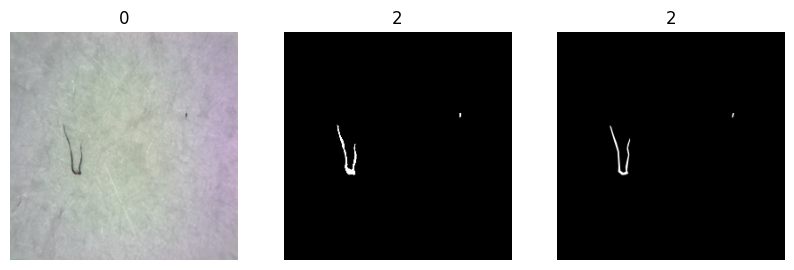

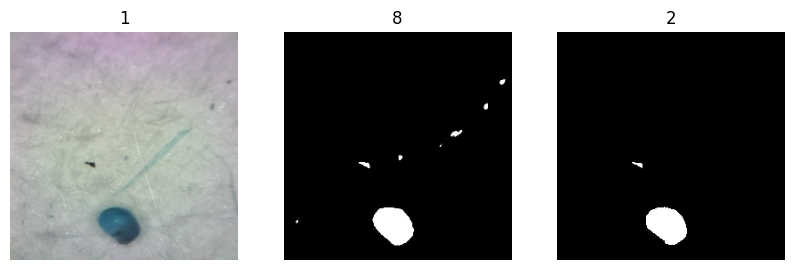

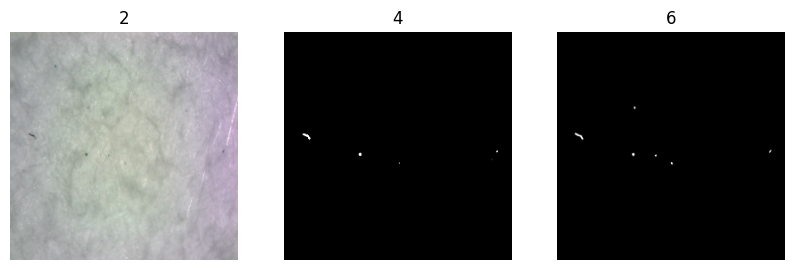

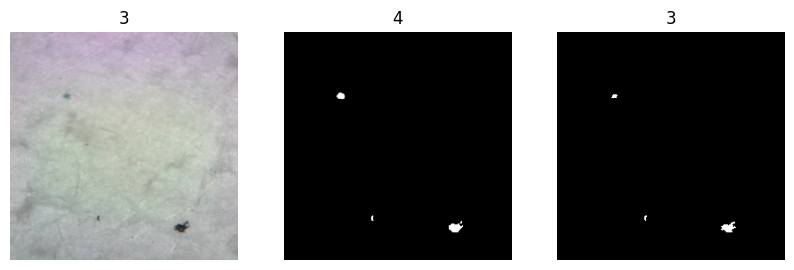

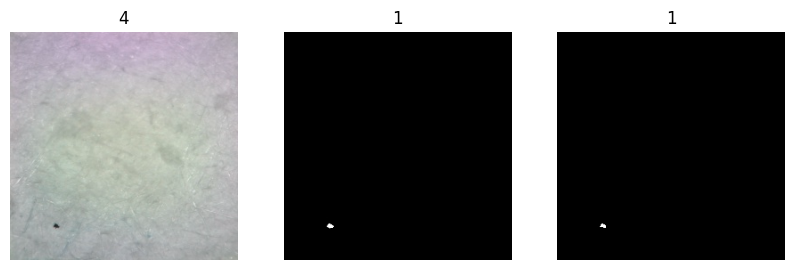

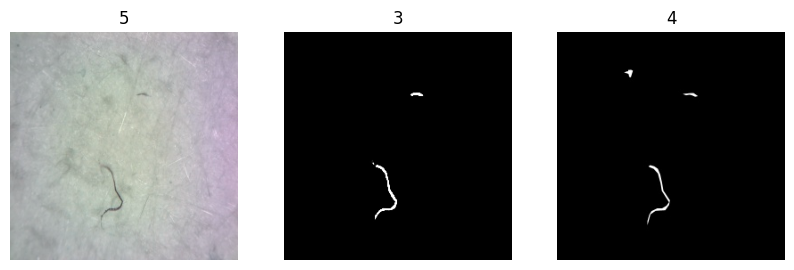

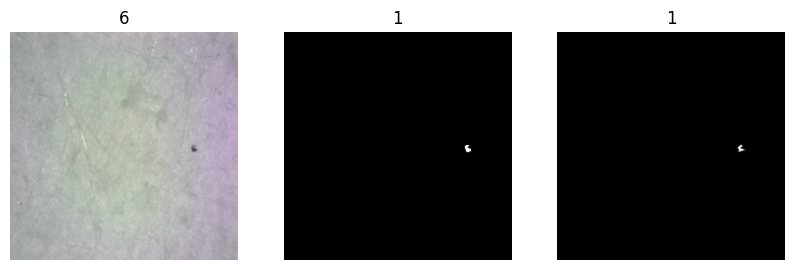

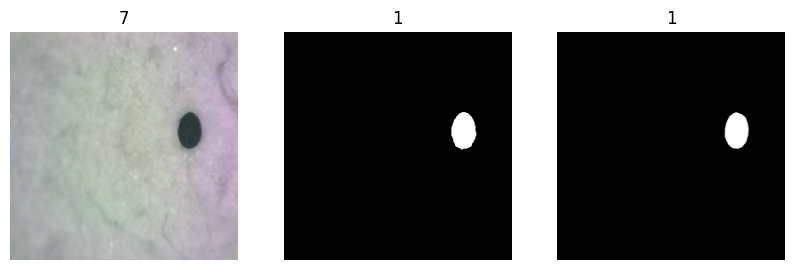

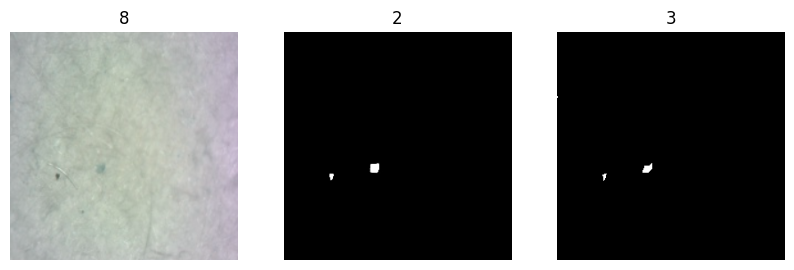

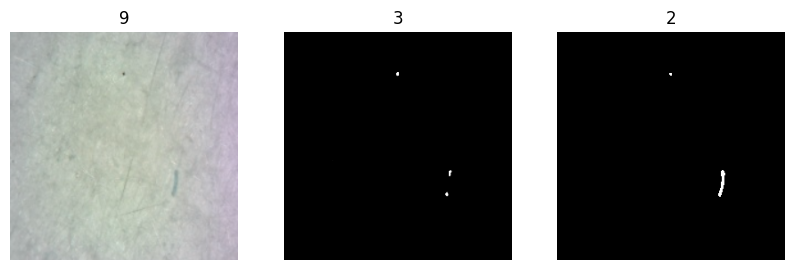

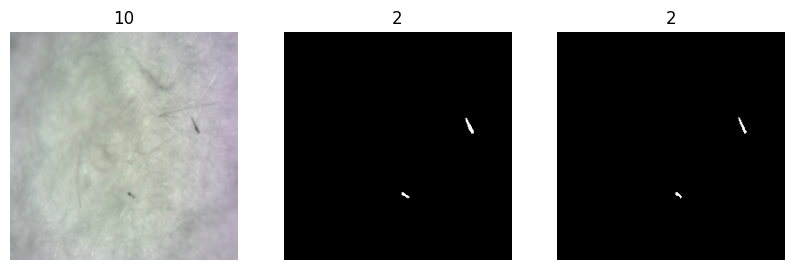

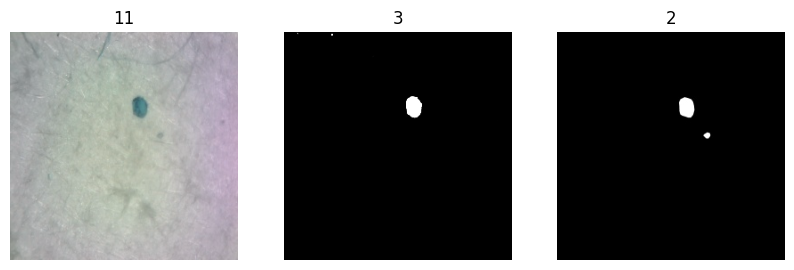

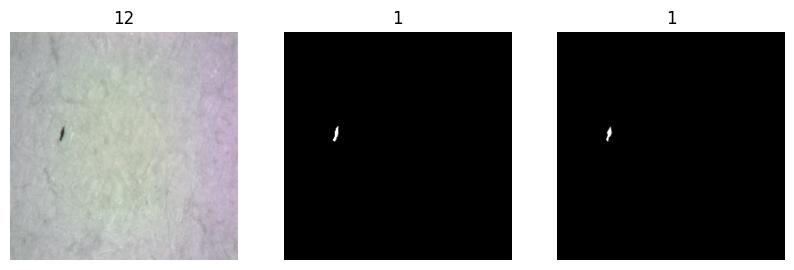

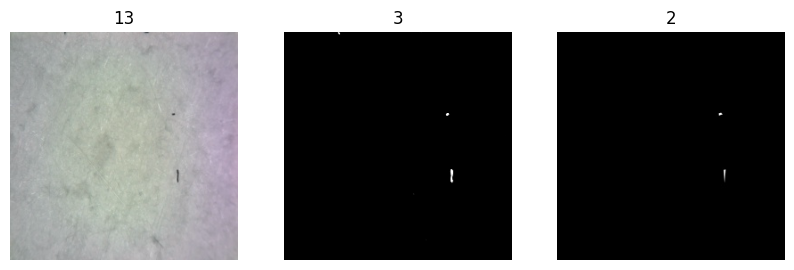

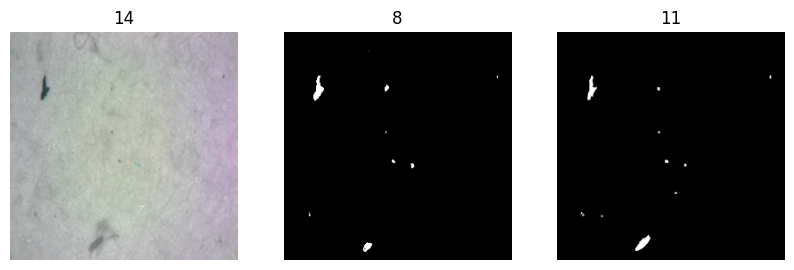

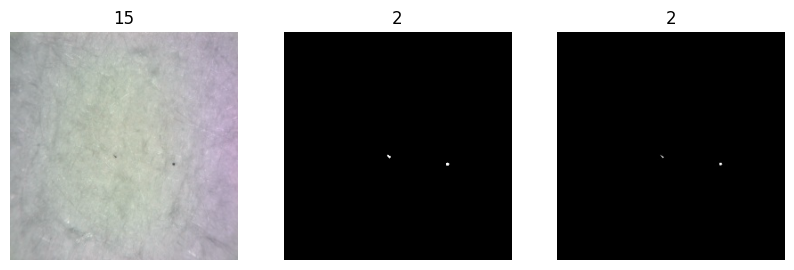

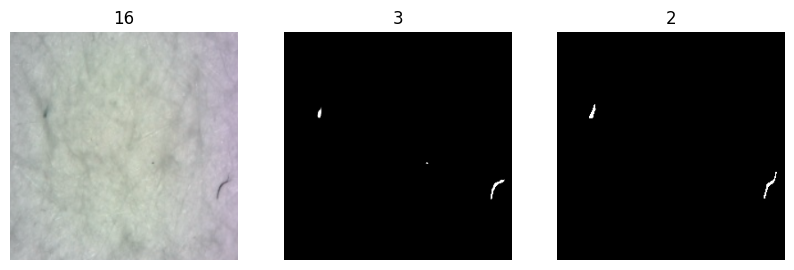

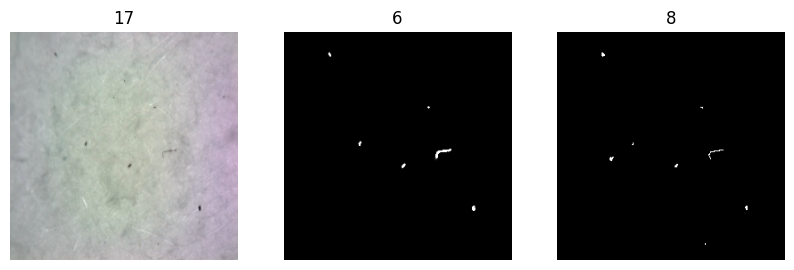

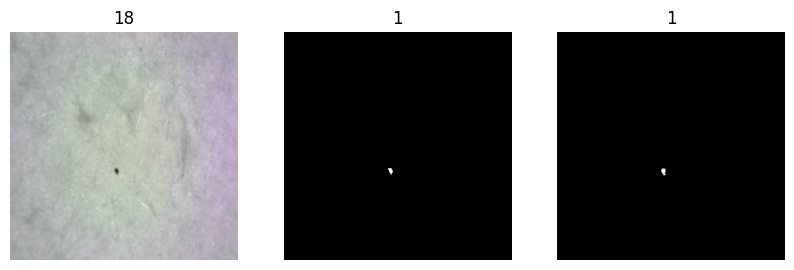

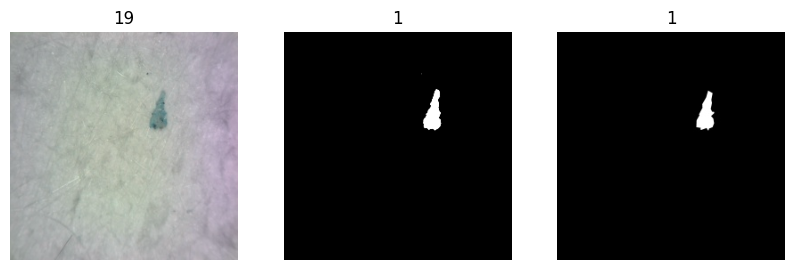

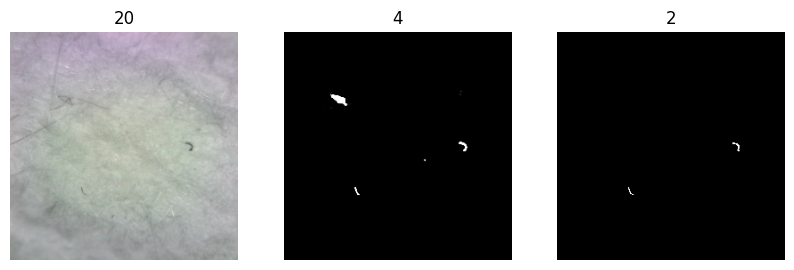

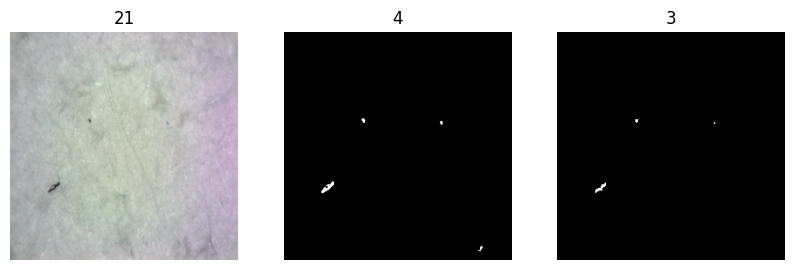

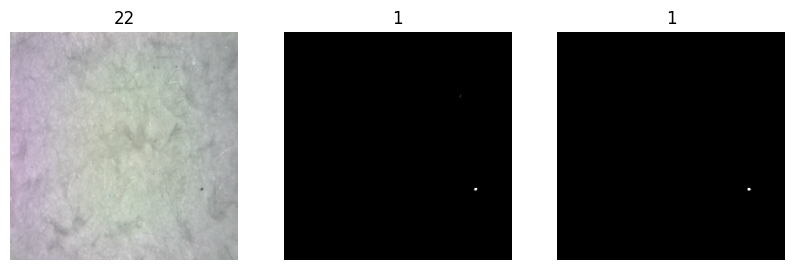

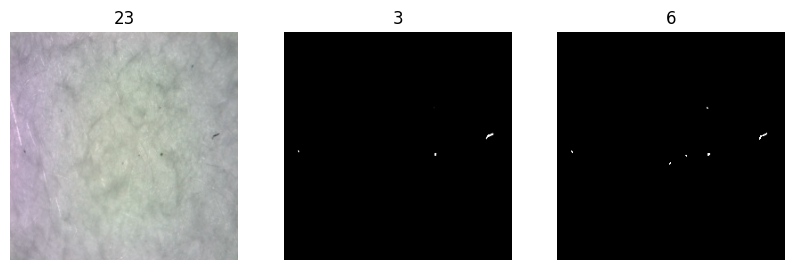

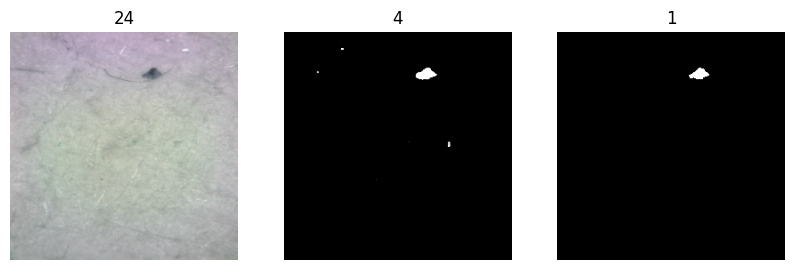

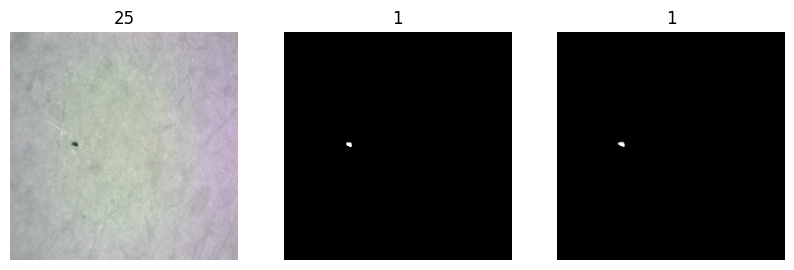

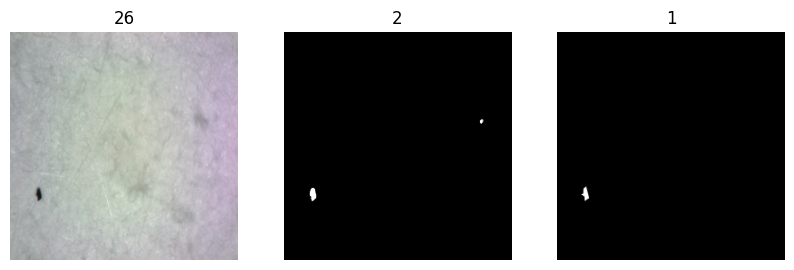

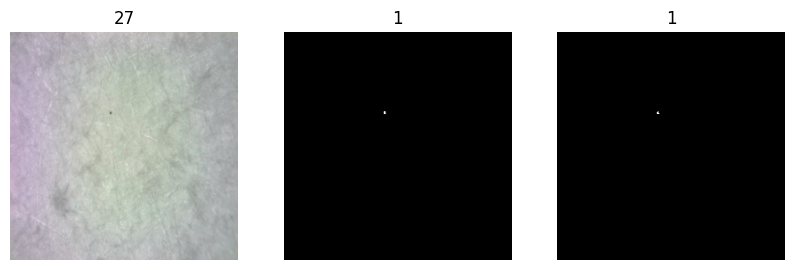

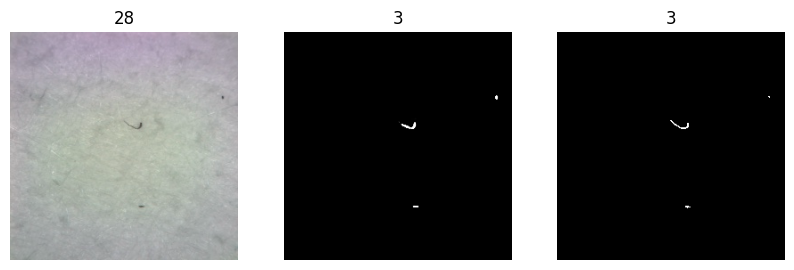

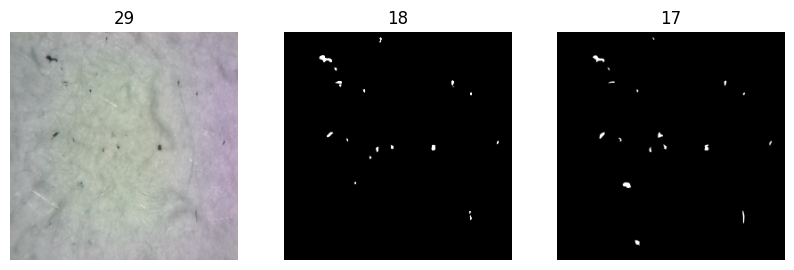

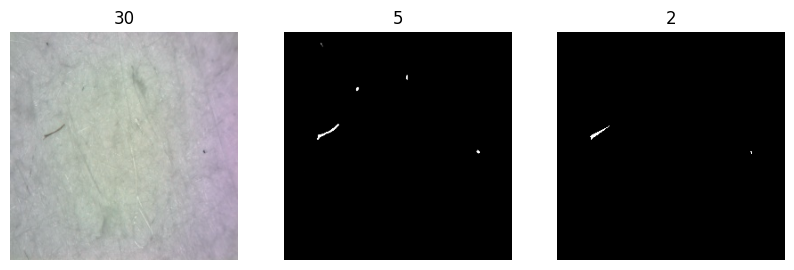

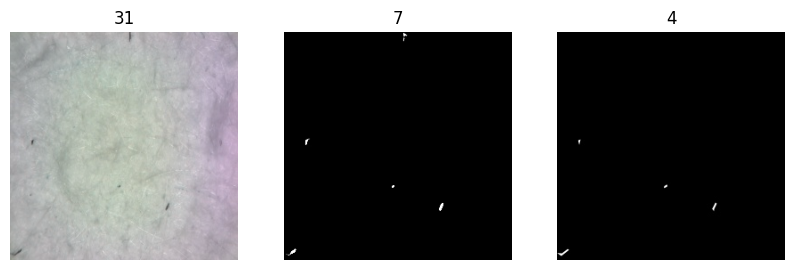

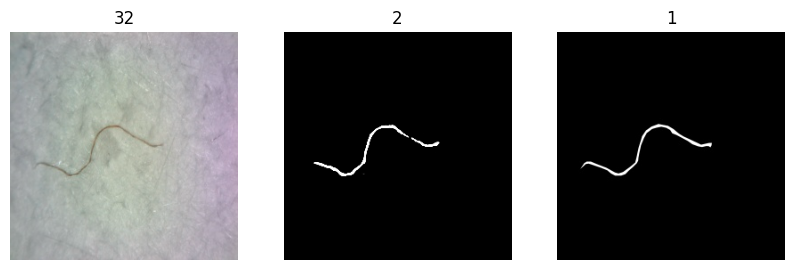

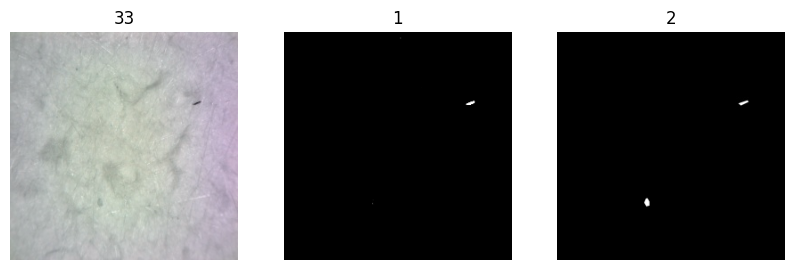

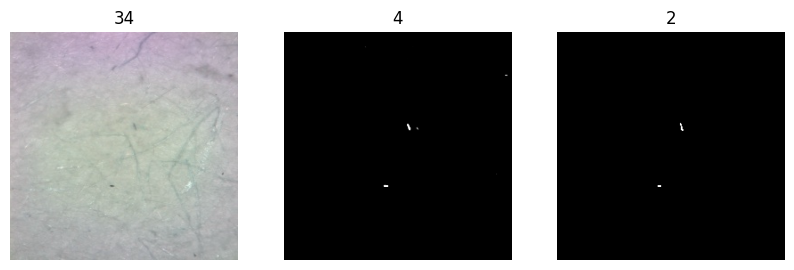

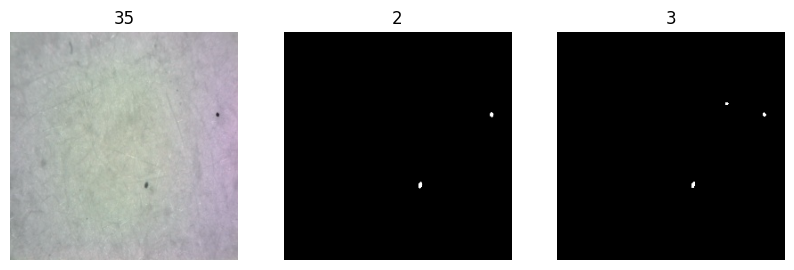

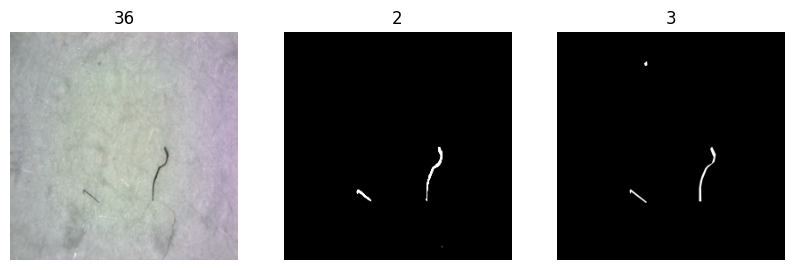

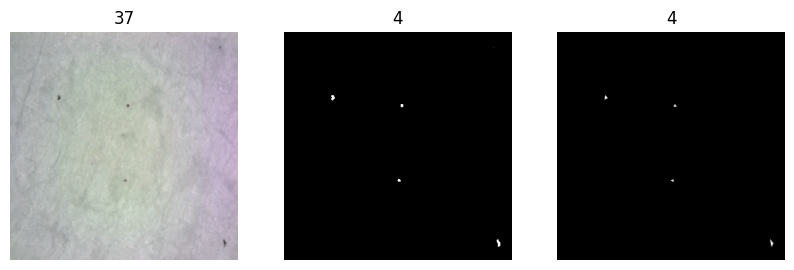

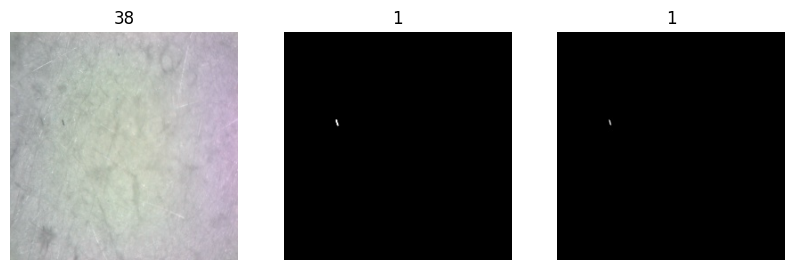

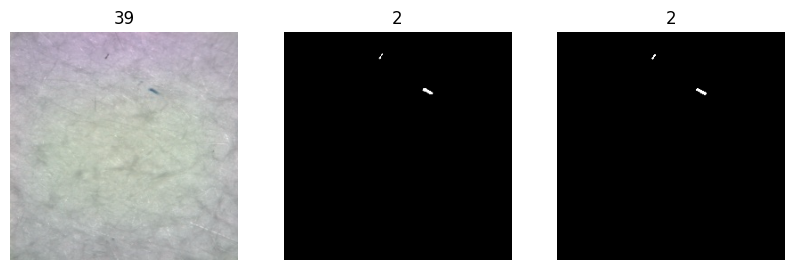

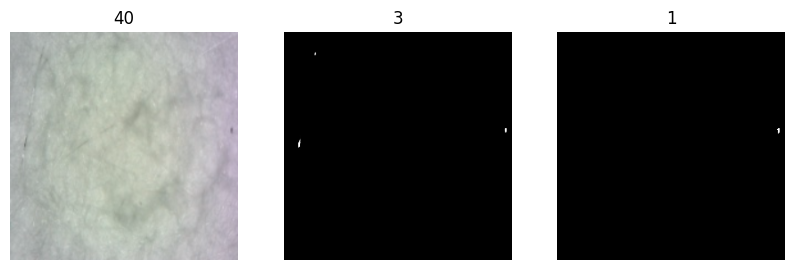

In [ ]:
FILTER_THRESHOLD = THRESHOLD

def predict_and_compare_image(images, labels, from_ind=0, to_ind=len(y_test), save_counts=False, model_name=None):
  print(f"Counting test dataset with model {current_model}...")
  images = images[from_ind:to_ind]
  labels = labels[from_ind:to_ind]
  total_mp_predicted = 0
  total_mp_actual = 0
  # Deep copy prediction masks because they'll be modified
  predictions = np.copy(base_predictions)
  ground_truth = np.copy(labels)

  data = {'predicted': [], 'actual': []}

  for i, (image, label) in enumerate(zip(images, labels)):
    abs_index = i + from_ind
    prediction = predictions[abs_index]

    predicted_count = count_blobs(prediction, threshold=FILTER_THRESHOLD * 255)
    actual_count = count_blobs(label)

    data['predicted'].append(predicted_count)
    data['actual'].append(actual_count)

    # Remove too small particles from mask
    # prediction = remove_too_small_particles(prediction)

    total_mp_predicted += predicted_count
    total_mp_actual += actual_count

    print(f'Image {abs_index}: predicted {predicted_count}, actual {actual_count}')
    show_images([abs_index, predicted_count, actual_count], image, prediction, label)

  # Construct dataframe and save
  if (save_counts):
    dataframe = pd.DataFrame(data=data)
    dataframe.to_csv(os.path.join(counting_dir, model_name + ".csv"))

  return total_mp_predicted, total_mp_actual

# total_mp_predicted, total_mp_actual = predict_and_compare_image(x_test, y_test, 0, 10)
total_mp_predicted, total_mp_actual = predict_and_compare_image(x_test, y_test, save_counts=True, model_name="combo")
print('Total predicted', total_mp_predicted, '. Total actual:', total_mp_actual)

### Model metrics graph

### Show metric graphs

In [ ]:
# Show metric graphs
import matplotlib.pyplot as plt

def show_training_metrics(data):
  # Plot training and validation accuracy
  plt.figure(figsize=(12, 6))
  plt.subplot(2, 2, 1)
  plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
  plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot training and validation loss
  plt.subplot(2, 2, 2)
  plt.plot(data['epoch'], data['loss'], label='Training Loss')
  plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Plot validation F1 Score, Precision, and Recall
  plt.subplot(2, 2, 3)
  plt.plot(data['epoch'], data['val_f1_score'], label='Validation F1 Score')
  plt.plot(data['epoch'], data['val_precision'], label='Validation Precision')
  plt.plot(data['epoch'], data['val_recall'], label='Validation Recall')
  plt.title('Validation F1 Score, Precision, and Recall')
  plt.xlabel('Epoch')
  plt.ylabel('Metric Value')
  plt.legend()

  # Plot validation F1 Score, Precision, and Recall
  plt.subplot(2, 2, 4)
  plt.plot(data['epoch'], data['val_binary_io_u'], label='Validation Binary IoU')
  plt.title('Validation Binary IoU')
  plt.xlabel('Epoch')
  plt.ylabel('Metric Value')
  plt.legend()

  plt.tight_layout()
  plt.show()

Metrics of wbce_200_thresh_50_relu_batch_4_filters_64


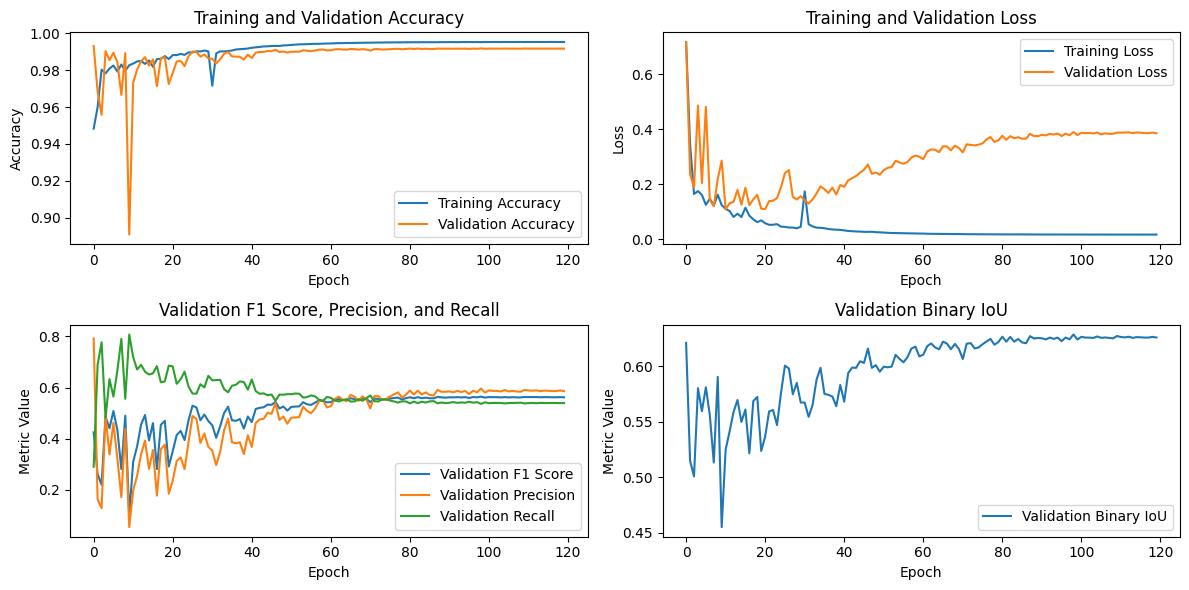

In [ ]:
# Load the CSV file
data = pd.read_csv(current_logger_dir)

print("Metrics of", current_model)
show_training_metrics(data)

In [ ]:
column = data['val_loss']
best_index = column.idxmin()
print(data.iloc[[best_index]])
best_epoch = best_index + 1

    epoch  accuracy  binary_io_u_1  f1_score      loss  precision_2  recall_2  \
39     39  0.991778       0.632214  0.520697  0.034728     0.385944  0.800026   

    val_accuracy  val_binary_io_u_1  val_f1_score  val_loss  val_precision_2  \
39      0.991293           0.563347      0.383395  0.039901         0.270376   

    val_recall_2  
39      0.658759  


### Compile best model

In [ ]:
val_loss = data['val_loss'][best_index]
model_name = f'weights.{best_epoch}-{round(val_loss, 2)}.hdf5'
best_model_checkpoint_dir = os.path.join(checkpoints_augmented_dir, model_name)

unet_model.load_weights(best_model_checkpoint_dir)

In [ ]:
unet_model.evaluate(val_dataset)

3/3 [==============================] - 32s 7s/step - loss: 0.0407 - accuracy: 0.9928 - binary_io_u: 0.6206 - precision: 0.4417 - recall: 0.6100 - f1_score: 0.5124


[0.04068025201559067,
 0.9927528500556946,
 0.6205804347991943,
 0.441663533449173,
 0.6100186109542847,
 0.5123657584190369]

In [ ]:
unet_model.evaluate(val_dataset)

3/3 [==============================] - 27s 7s/step - loss: 0.0407 - accuracy: 0.9928 - binary_io_u_2: 0.6730 - precision_4: 0.5812 - recall_4: 0.5271 - f1_score: 0.5528


[0.04068025201559067,
 0.9927528500556946,
 0.673003613948822,
 0.5811936259269714,
 0.5271165370941162,
 0.5528357028961182]

# Kursinio paveiksleliai/figuros

In [ ]:
# Load the CSV file
data = pd.read_csv(current_logger_dir)

### Load single image for testing

In [ ]:
img_name = "20211223110538.jpg"
image_path = os.path.join(resized_images_dir, img_name)
mask_path = os.path.join(resized_masks_dir, img_name)
img = cv.imread(image_path) / 255.0
mask = cv.imread(mask_path) / 255.0

### Augmentation example

In [ ]:
augmented_image, augmented_mask = augment(img, mask, override_augmentation=0)

augmented_path = os.path.join(resized_images_dir, img_name.replace(".jpg", "_horflip.jpg"))
# cv.imwrite(augmented_path, augmented_image.numpy() * 255.0)
show_images(img, mask)
show_images(augmented_image, augmented_mask)

### Create image for showcasing binary segmentation

In [ ]:
temp_img = np.expand_dims(img, axis=0)
predicted_mask = unet_model.predict(temp_img)
predicted_mask = np.squeeze(predicted_mask, axis=0)
# predicted_mask = np.where(predicted_mask < 0.5, 0, 1)

1/1 [==============================] - 1s 740ms/step


(44, 44, 3)


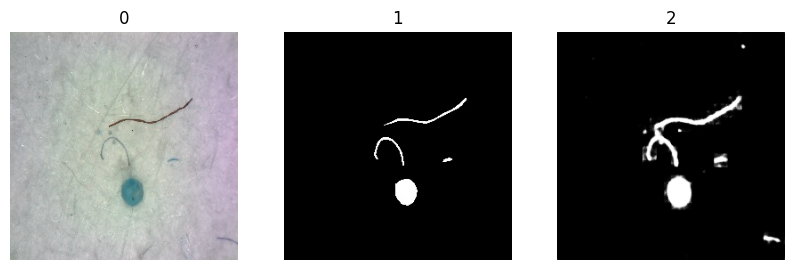

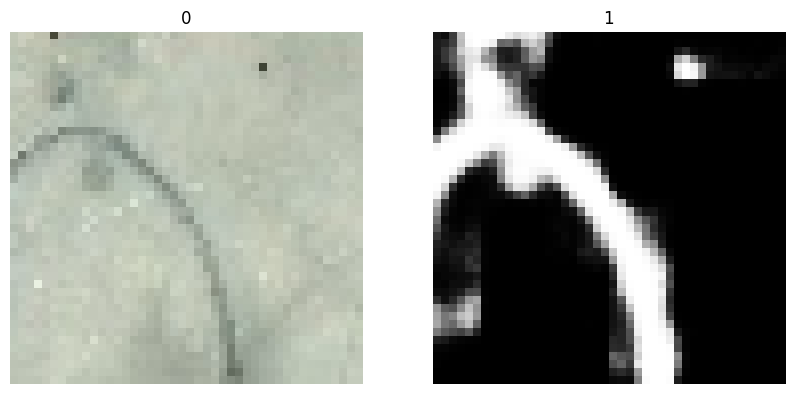

In [ ]:
def zoom(image, mask, zoom_factor):
  new_image = tf.image.central_crop(image, central_fraction=1/zoom_factor)  # Zoom in to 70% of the image
  # new_image = tf.image.resize(new_image, [INPUT_SHAPE[0], INPUT_SHAPE[1]])
  new_mask = tf.image.central_crop(mask, central_fraction=1/zoom_factor)
  # new_mask = tf.image.resize(new_mask, [INPUT_SHAPE[0], INPUT_SHAPE[1]])
  return new_image, new_mask

img_zoom, mask_zoom = zoom(img, predicted_mask, 6)
show_images(img, mask, predicted_mask)
show_images(img_zoom, mask_zoom)

print(img_zoom.shape)

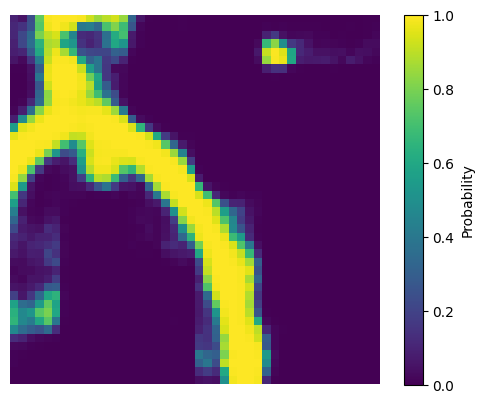

In [ ]:
# Save the original image
plt.imshow(img_zoom)
plt.axis('off')  # Turn off axis
plt.savefig(os.path.join(figures_dir, "segmentation_image.png"), bbox_inches='tight', pad_inches=0)

# Save the segmentation mask
plt.imshow(mask_zoom, cmap='viridis', vmin=0, vmax=1)
plt.axis('off')  # Turn off axis
plt.colorbar(label='Probability')
plt.savefig(os.path.join(figures_dir, "segmentation_mask.png"), bbox_inches='tight', pad_inches=0)

### Create img for dice loss training

In [ ]:
plt.rcParams.update({'font.size': 14})

Metrics of dice_smooth_1eminus5_thresh_50_relu_batch_4_filters_64


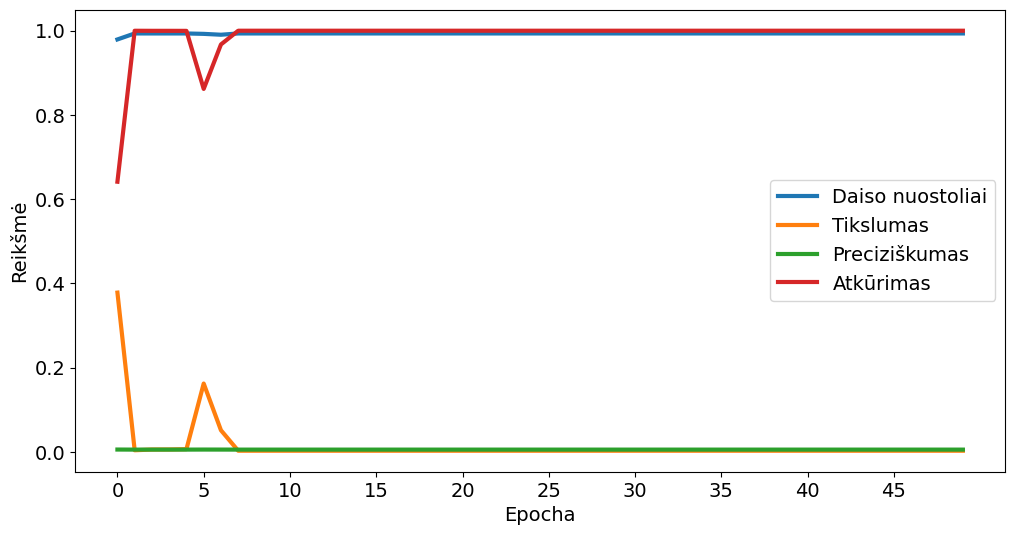

In [ ]:
# Show metric graphs
import matplotlib.pyplot as plt

epochs = 50

def show_training_metrics(data):
  # Plot training and validation accuracy
  plt.figure(figsize=(12, 6))
  linewidth=3.0
  plt.plot(data['epoch'], data['loss'], label='Daiso nuostoliai', linewidth=linewidth)
  # plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
  plt.plot(data['epoch'], data['accuracy'], label='Tikslumas', linewidth=linewidth)
  plt.plot(data['epoch'], data['precision'], label='Preciziškumas', linewidth=linewidth)
  plt.plot(data['epoch'], data['recall'], label='Atkūrimas', linewidth=linewidth)
  # plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
  # plt.title('Dice loss training metrics')
  plt.xlabel('Epocha')
  plt.ylabel('Reikšmė')
  plt.xticks(np.arange(0, epochs, 5))
  plt.legend()

  plt.savefig(os.path.join(figures_dir, "dice_training.png"), bbox_inches='tight', pad_inches=0.1)
  plt.show()

print("Metrics of", current_model)
show_training_metrics(data[:epochs])

### Save test dataset images for latex

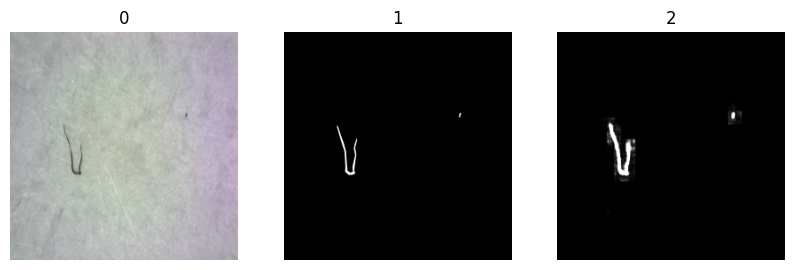

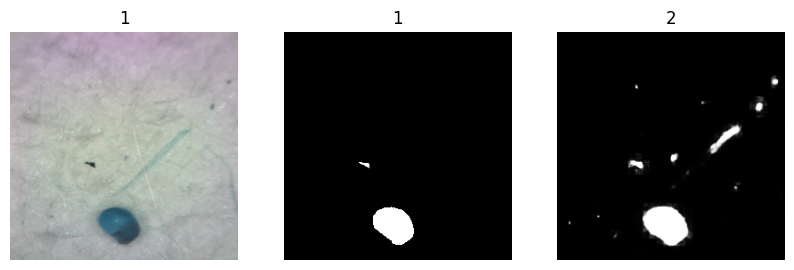

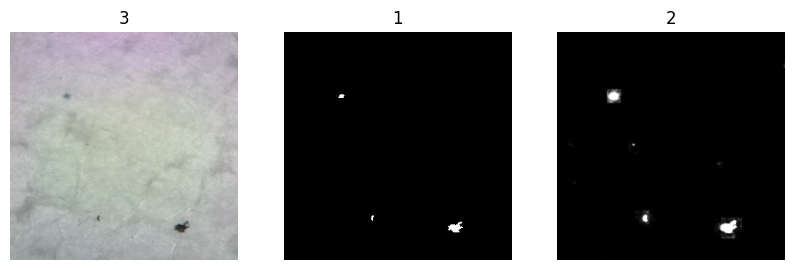

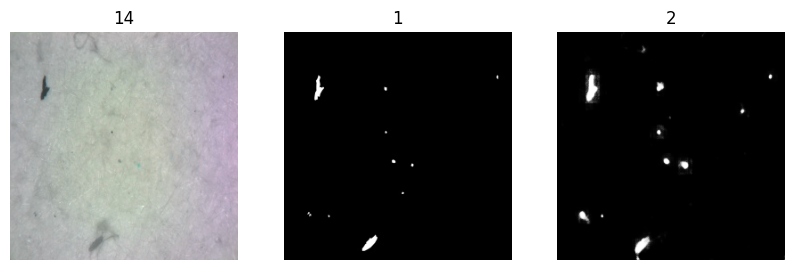

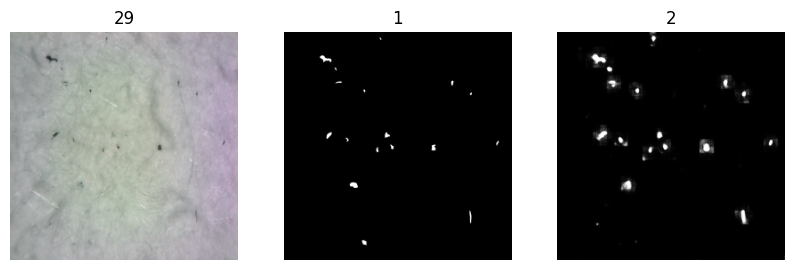

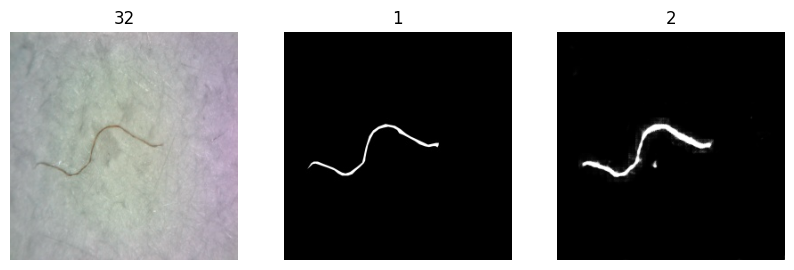

In [ ]:
from PIL import Image

figures_test_dir = os.path.join(figures_dir, "test_dataset")
figures_wbce_test_dir = os.path.join(figures_dir, "test_dataset_wbce")

def save_numpy_as_image(array, path):
    """
    Saves a numpy array as an image.

    Parameters:
        array (numpy.ndarray): The image data as a numpy array.
        path (str): The path where the image will be saved.
    """
    # If the image is binary (i.e., has a shape like (256, 256, 1)),
    # we should first remove the singleton dimension before saving it
    if array.ndim == 3 and array.shape[-1] == 1:
        array = array.squeeze(-1)

    # Convert the numpy array to a PIL image
    image = Image.fromarray(np.uint8(array * 255))

    # Save the image
    image.save(path)

    print(f"Image saved as {path}")


def save_image(ds_x, ds_y, predictions, index, dir=figures_test_dir):
  image = ds_x[index]
  labels = ds_y[index]
  prediction = predictions[index]

  save_numpy_as_image(image, os.path.join(dir, "image_" + str(index) + ".png"))
  save_numpy_as_image(labels, os.path.join(dir, "label_" + str(index) + ".png"))
  save_numpy_as_image(prediction, os.path.join(dir, "prediction_" + str(index) + ".png"))

def show_test_images(ds_x, ds_y, predictions, index):
  image = ds_x[index]
  labels = ds_y[index]
  prediction = predictions[index]
  show_images([index], image, labels, prediction)

# save_image(x_test, y_test, base_predictions, 0, figures_wbce_test_dir)
# save_image(x_test, y_test, base_predictions, 1, figures_wbce_test_dir)
# save_image(x_test, y_test, base_predictions, 3, figures_wbce_test_dir)
# save_image(x_test, y_test, base_predictions, 14, figures_wbce_test_dir)
# save_image(x_test, y_test, base_predictions, 29, figures_wbce_test_dir)
# save_image(x_test, y_test, base_predictions, 32, figures_wbce_test_dir)
show_test_images(x_test, y_test, base_predictions, 0)
show_test_images(x_test, y_test, base_predictions, 1)
show_test_images(x_test, y_test, base_predictions, 3)
show_test_images(x_test, y_test, base_predictions, 14)
show_test_images(x_test, y_test, base_predictions, 29)
show_test_images(x_test, y_test, base_predictions, 32)